In [8]:
import os
import pandas as pd
from PIL import Image
import numpy as np

# Đường dẫn đến DataSet
root_path = r"dataset"

cls_lst = ['Drowsy', 'Non Drowsy']

# Hàm để đọc dữ liệu từ thư mục
# Hàm để đọc dữ liệu từ thư mục
def load_data_with_bbox(data_dir, target_size=(128, 128)):
    """
    Đọc dữ liệu và resize ảnh về kích thước target_size, đồng thời điều chỉnh lại bounding box.
    Ảnh được giữ ở định dạng grayscale (1 kênh).

    Args:
        data_dir (str): Đường dẫn đến thư mục chứa dữ liệu.
        target_size (tuple): Kích thước mong muốn của ảnh (width, height).

    Returns:
        images (list): Danh sách ảnh grayscale đã resize (numpy array, shape: target_size + (1,)).
        bboxes_with_classes (list): Danh sách [[xmin, ymin, width, height], class].
    """
    # Đọc file _annotations.csv
    annotations = pd.read_csv(os.path.join(data_dir, "_annotations.csv"))

    # Tách dữ liệu ảnh và nhãn
    images = []  # Danh sách chứa ảnh grayscale đã resize
    bboxes_with_classes = []  # Danh sách chứa [[xmin, ymin, width, height], class]

    for _, row in annotations.iterrows():
        img_path = os.path.join(data_dir, str(row['filename']))
        if os.path.exists(img_path):
            # Mở ảnh và lấy kích thước ban đầu
            img = Image.open(img_path).convert("RGB")
            original_width, original_height = img.size

            # Resize ảnh về kích thước target_size
            img_resized = img.resize(target_size)

            # Chuyển đổi sang ảnh xám (grayscale)
            img_gray = img_resized.convert("L")

            # Chuyển thành numpy array và thêm chiều kênh (shape: 128, 128, 1)
            img_array = np.array(img_gray)
            img_array = np.expand_dims(img_array, axis=-1)

            # Chuẩn hóa dữ liệu về khoảng [0, 1]
            img_array = img_array / 255.0

            images.append(img_array)

            # Tính toán tỷ lệ thay đổi kích thước
            scale_x = target_size[0] / original_width
            scale_y = target_size[1] / original_height

            # Điều chỉnh bounding box cho phù hợp với ảnh đã resize
            xmin = row['xmin'] * scale_x
            ymin = row['ymin'] * scale_y
            xmax = row['xmax'] * scale_x
            ymax = row['ymax'] * scale_y

            # Tạo bounding box với nhãn lớp
            bbox = [xmin, ymin, xmax - xmin, ymax - ymin]
            class_id = 0 if row['class'] == "Drowsy" else 1  # 0: Drowsy, 1: Non Drowsy
            bboxes_with_classes.append([bbox, class_id])

    return images, bboxes_with_classes

# Đọc dữ liệu
X_train, y_train = load_data_with_bbox(os.path.join(root_path, "train"))
X_test, y_test = load_data_with_bbox(os.path.join(root_path, "test"))
X_val, y_val = load_data_with_bbox(os.path.join(root_path, "valid"))

# Chuyển danh sách thành numpy array
X_train = np.array(X_train)  # Shape: (n_train, 128, 128, 1)
X_test = np.array(X_test)    # Shape: (n_test, 128, 128, 1)
X_val = np.array(X_val)      # Shape: (n_val, 128, 128, 1)

# Tách bounding box và nhãn lớp từ y
y_train_boxes = np.array([item[0] for item in y_train])  # Shape: (n_train, 4)
y_train_labels = np.array([item[1] for item in y_train]) # Shape: (n_train,)
y_test_boxes = np.array([item[0] for item in y_test])    # Shape: (n_test, 4)
y_test_labels = np.array([item[1] for item in y_test])   # Shape: (n_test,)
y_val_boxes = np.array([item[0] for item in y_val])      # Shape: (n_val, 4)
y_val_labels = np.array([item[1] for item in y_val])     # Shape: (n_val,)

In [9]:
# Kiểm tra dữ liệu
print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}, Validation samples: {len(X_val)}")
print(f"Example resized image shape (train): {X_train[0].shape}")  # Kích thước ảnh đầu tiên
print(f"Example bbox with class (train): {y_train[0]}")  # Bounding box và lớp của ảnh đầu tiên

Train samples: 1724, Test samples: 370, Validation samples: 369
Example resized image shape (train): (128, 128, 1)
Example bbox with class (train): [[15.0, 24.0, 107.0, 39.0], 1]


Hàm chuyển bbox (x_min, y_min, w, h) thành (x_center, y_center)

In [10]:
import torch

# Hàm chuyển đổi bbox thành điểm trung tâm
def bbox_to_center(bbox):
  # bbox: [x_min, y_min, w, h]
  x_center = bbox[0] + bbox[2]/2
  y_center = bbox[1] + bbox[3]/2
  return int(x_center), int(y_center)


def bbox_to_segmentation(size_wh, bboxes, grid_size=16, num_classes=2):
  """
  Convert bounding box annotations to segmentation maps for training.
  Mỗi ô trong lưới có giá trị = 1 nếu nó giao với bbox, và 0 nếu không.
  """
  h, w, _ = size_wh  # Sửa cách unpack cho ảnh grayscale (128, 128, 1)
  seg_map = torch.zeros((num_classes + 1, grid_size, grid_size), dtype=torch.float32)  # Khởi tạo segmentation map

  seg_map[0, :, :] = 1.0  # Background: mặc định là 1.0 ở tất cả các ô

  # Tính toán kích thước mỗi cell (ô lưới)
  cell_h, cell_w = h / grid_size, w / grid_size

  # Duyệt qua tất cả các bounding box trong bboxes
  # bboxes: [[xmin, ymin, width, height], class_id]
  bbox = bboxes[0]  # Bounding box: [xmin, ymin, width, height]
  class_id = bboxes[1]  # Lớp đối tượng (class_id)
  #print(bbox)
  x_min, y_min, width, height = bbox
  x_max = x_min + width
  y_max = y_min + height

  # Chuyển đổi bbox thành các chỉ số ô lưới (grid cells)
  grid_x_min = max(0, int(x_min // cell_w))
  grid_y_min = max(0, int(y_min // cell_h))
  grid_x_max = min(grid_size - 1, int(x_max // cell_w))
  grid_y_max = min(grid_size - 1, int(y_max // cell_h))

  # Cập nhật segmentation map cho tất cả các ô lưới có giao nhau với bbox
  for grid_x in range(grid_x_min, grid_x_max + 1):
    for grid_y in range(grid_y_min, grid_y_max + 1):
      if 0 <= grid_x < grid_size and 0 <= grid_y < grid_size:
        seg_map[class_id + 1, grid_x, grid_y] = 1.0  # Đánh dấu lớp đối tượng
        seg_map[0, grid_x, grid_y] = 0.0  # Đánh dấu không phải background

  return seg_map

Hàm chuyển đổi seg_map thành center và hàm vẽ

In [11]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def export_center(predicted, image_wh):
  #x, y = torch.where(predicted == 1)
  x, y = torch.where(torch.isin(predicted, torch.tensor([1, 2])))
  h, w, _ = image_wh
  print(image.size)
  cell_h, cell_w = h / 16, w / 16

  center_lst = []

  for i in range(len(x)):
    center_x = int((x[i] + 0.5) * cell_w)
    center_y = int((y[i] + 0.5) * cell_h)
    center_lst.append([center_x, center_y])
  return center_lst

def draw_center(image, center_lst):
  image_pil = Image.fromarray((image.squeeze() * 255).astype(np.uint8), mode='L')
  image_draw = image_pil.copy()
  draw = ImageDraw.Draw(image_draw)
  color = 255  # Màu trắng cho ảnh grayscale
  radius = 0.5  # Tăng radius để dễ nhìn hơn
  for center_x, center_y in center_lst:
    draw.ellipse((center_x - radius, center_y - radius, center_x + radius, center_y + radius), fill=color)
  return image_draw

Index: 1412
Segmentation map (max): tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]])
16384


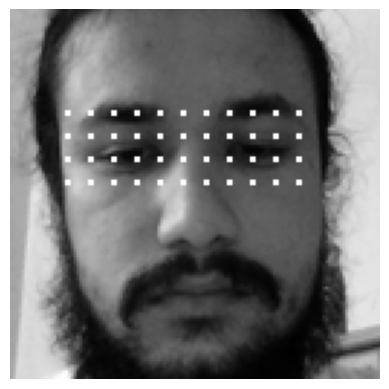

In [16]:
# Kiểm tra
import random
idx = random.randint(0, len(X_train) - 1)
print("Index:", idx)

image = X_train[idx]
y = bbox_to_segmentation(image.shape, y_train[idx], 16, num_classes=2).unsqueeze(0)
_, y_ = torch.max(y, 1)

print("Segmentation map (max):", y_)

# Hiển thị ảnh với trung tâm
plt.imshow(draw_center(image, export_center(y_[0], image.shape)), cmap='gray')
plt.axis('off')
plt.show()

Class Dataset

In [17]:
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image

class DrowsinessDetectionFOMODataset(Dataset):
  def __init__(self, images, bboxes, grid_size=16, num_classes=2, transform=None):
    self.images = images  # Dữ liệu đầu vào
    self.bboxes = bboxes  # phân loại tương ứng
    self.num_classes = num_classes
    self.transform = transform
    self.grid_size = grid_size

  def __len__(self):
    return len(self.images)  # Số lượng mẫu trong dataset

  def __getitem__(self, idx):
    # Trả về một cặp (dữ liệu, nhãn) cho chỉ số idx
    # waveform = np.load(self.data[idx])
    image = self.images[idx]
    bboxes = self.bboxes[idx]

    # Tạo segmentation map
    target = bbox_to_segmentation(image.shape, bboxes, self.grid_size, num_classes=self.num_classes)

    # Chuyển numpy array thành PIL Image (grayscale)
    image_pil = Image.fromarray((image.squeeze() * 255).astype(np.uint8), mode='L')

    # Áp dụng transform nếu có
    if self.transform:
      image_pil = self.transform(image_pil)  # Transform trả về tensor
      return image_pil, target  # Trả về trực tiếp tensor từ transform

    # Nếu không có transform, chuyển thành tensor thủ công
    image_tensor = torch.tensor(np.array(image_pil), dtype=torch.float32).unsqueeze(0) / 255.0  # Shape: (1, 128, 128)
    return image_tensor, target

In [18]:
import torch
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),   # Chuyển PIL Image thành tensor (shape: 1, 128, 128)
    transforms.Normalize(mean=[0.5], std=[0.5])  # Chuẩn hóa cho ảnh grayscale
])

train_dataset = DrowsinessDetectionFOMODataset(X_train, y_train, grid_size=16, transform=transform)
val_dataset = DrowsinessDetectionFOMODataset(X_val, y_val, grid_size=16, transform=transform)
test_dataset = DrowsinessDetectionFOMODataset(X_test, y_test, grid_size=16, transform=transform)

In [19]:
from torch.utils.data import DataLoader

# Tạo DataLoader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
print("Number of batches in train_loader:", len(train_loader))

# Lấy batch đầu tiên và kiểm tra
for images, targets in train_loader:
    # Chuyển dữ liệu sang device
    images = images.to(device)
    targets = targets.to(device)

    print("Images shape:", images.shape)
    print("Targets shape:", targets.shape)
    print("Targets (segmentation map):")
    print(targets)
    print("Unique values in targets:", torch.unique(targets))
    break

Number of batches in train_loader: 1724
Images shape: torch.Size([1, 1, 128, 128])
Targets shape: torch.Size([1, 3, 16, 16])
Targets (segmentation map):
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
          [

Tạo Model

In [20]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Cấu hình Model

In [21]:
import torch.nn as nn
import torch.nn.functional as F
import os
import sys
sys.path.append(r"D:\Duc_PC\Hoc_AI_lap_trinh\notebook_edge_ai\JupyterNotebook\mobilenetv2.pytorch")
from models.imagenet import mobilenetv2

class FOMOWithMobileNetV2(nn.Module):
    def __init__(self, input_channels=1, input_size=(128, 128), alpha=0.1, num_classes=3, pretrain_path=''):
        super(FOMOWithMobileNetV2, self).__init__()

        # Load MobileNetV2 backbone với alpha=0.1
        backbone = mobilenetv2(width_mult=alpha)
        if os.path.exists(pretrain_path):
            backbone.load_state_dict(torch.load(pretrain_path, map_location=torch.device('cpu')), strict=False)

        # Truncate MobileNetV2 đến block 5 (stride 8)
        self.feature_extractor = nn.Sequential(*list(backbone.features)[:5])  

        # Lấy số kênh đầu ra của feature_extractor
        sample_input = torch.randn(1, 3, 128, 128)  # Test đầu ra
        with torch.no_grad():
            output_shape = self.feature_extractor(sample_input).shape
        num_feature_channels = output_shape[1]  # Số kênh của feature map

        # Head layers cho object detection
        self.head = nn.Sequential(
            nn.Conv2d(num_feature_channels, num_feature_channels, kernel_size=3, stride=1, padding=1, groups=num_feature_channels),  # Depthwise
            nn.Conv2d(num_feature_channels, 16, kernel_size=1, stride=1),  # Pointwise giảm xuống 16 kênh
            nn.ReLU(inplace=True)
        )
        
        # Đảm bảo đầu ra có kích thước [1, 3, 16, 16]
        self.logits = nn.Conv2d(16, num_classes+1, kernel_size=1, stride=1)  # num_classes = 3 (3 classes)

    def forward(self, x):
        # Chuyển từ 1 kênh sang 3 kênh bằng repeat (đúng chuẩn hơn)
        x = x.repeat(1, 3, 1, 1)  

        # Trích xuất đặc trưng
        x = self.feature_extractor(x)
        
        # Áp dụng head layers
        x = self.head(x)
        
        # Đảm bảo kích thước đầu ra là 16x16 thay vì 8x8
        x = nn.functional.interpolate(x, size=(16, 16), mode='bilinear', align_corners=False)
        
        x = self.logits(x)  # Logits output với shape (batch_size, 3, 16, 16)
        return x

In [22]:
from torchsummary import summary

# Đường dẫn đầy đủ đến pretrained weights
pretrain_path = r"D:\Duc_PC\Hoc_AI_lap_trinh\notebook_edge_ai\JupyterNotebook\mobilenetv2.pytorch\pretrained\mobilenetv2_0.1-7d1d638a.pth"

model = FOMOWithMobileNetV2(input_channels=1, input_size=(128, 128), num_classes=2, pretrain_path=pretrain_path)
model.to(device)
summary(model, input_size=(1, 128, 128))  # Sửa input_size cho grayscale

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 64, 64]             108
       BatchNorm2d-2            [-1, 4, 64, 64]               8
             ReLU6-3            [-1, 4, 64, 64]               0
            Conv2d-4            [-1, 4, 64, 64]              36
       BatchNorm2d-5            [-1, 4, 64, 64]               8
             ReLU6-6            [-1, 4, 64, 64]               0
            Conv2d-7            [-1, 4, 64, 64]              16
       BatchNorm2d-8            [-1, 4, 64, 64]               8
  InvertedResidual-9            [-1, 4, 64, 64]               0
           Conv2d-10           [-1, 24, 64, 64]              96
      BatchNorm2d-11           [-1, 24, 64, 64]              48
            ReLU6-12           [-1, 24, 64, 64]               0
           Conv2d-13           [-1, 24, 32, 32]             216
      BatchNorm2d-14           [-1, 24,

Tạo Loss Function, Optimizer, Training
Thiết lập thông số Train

In [23]:
learning_rate = 0.001
epochs = 500
batch_size = 32

# Kiểm tra kích thước dataset
print("Số mẫu trong train_dataset:", len(train_dataset))
if len(train_dataset) < batch_size:
    batch_size = len(train_dataset)
    print(f"Batch size lớn hơn số mẫu, giảm batch_size xuống: {batch_size}")

Số mẫu trong train_dataset: 1724


Khởi tạo
Tính class_weights

In [24]:
import torch
import numpy as np

def calculate_class_weights(dataset, num_classes=2, grid_size=16):
    """
    Tính trọng số lớp dựa trên tần suất xuất hiện trong segmentation map.

    Args:
        dataset: Dataset chứa images và targets (DrowsinessDetectionFOMODataset).
        num_classes: Số lớp đối tượng (không tính background, mặc định 2).
        grid_size: Kích thước lưới (mặc định 16).

    Returns:
        torch.Tensor: Trọng số cho từng lớp (background, Drowsy, Non Drowsy).
    """
    # Khởi tạo mảng đếm số ô cho mỗi lớp
    class_counts = np.zeros(num_classes + 1)  # +1 cho background
    total_pixels = 0

    # Duyệt qua dataset
    for _, target in dataset:
        # target: (3, 16, 16) dạng one-hot
        target_indices = torch.argmax(target, dim=0)  # Chuyển sang (16, 16) dạng class indices
        # Đếm số ô cho mỗi lớp
        for cls in range(num_classes + 1):
            class_counts[cls] += (target_indices == cls).sum().item()
        total_pixels += target_indices.numel()  # Tổng số ô (16 * 16)

    # Tính trọng số: nghịch đảo tần suất chuẩn hóa
    class_weights = total_pixels / (num_classes + 1) / class_counts
    # Tránh chia cho 0 (nếu lớp nào không xuất hiện)
    class_weights = np.where(class_counts > 0, class_weights, 1.0)
    # Chuẩn hóa để trọng số không quá lớn
    class_weights = class_weights / class_weights.min()

    return torch.tensor(class_weights, dtype=torch.float32)

# Tính class weights từ train_dataset
#class_weights = calculate_class_weights(train_dataset, num_classes=2, grid_size=16)
#print("Class weights (background, Drowsy, Non Drowsy):", class_weights)

In [25]:
import torch.optim as optim
import torch.nn as nn
import torch
from torch.utils.data import DataLoader

# Tính class weights
class_weights = calculate_class_weights(train_dataset, num_classes=2, grid_size=16)
print("Class weights (background, Drowsy, Non Drowsy):", class_weights)
class_weights = class_weights.to(device)  # [background, Drowsy, Non Drowsy]
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Khởi tạo optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Tạo DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Số batch trong train_loader:", len(train_loader))
print("Số batch trong val_loader:", len(val_loader))
print("Số batch trong test_loader:", len(test_loader))

Class weights (background, Drowsy, Non Drowsy): tensor([1.0000, 5.2747, 4.8078])
Số batch trong train_loader: 54
Số batch trong val_loader: 12
Số batch trong test_loader: 12


Huấn luyện

In [26]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_model_path = r"model\best_model_grayscale_128x128_24_05_2025.pth"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on {device}")

# Chuyển model sang device
model = model.to(device)

# Early stopping
best_val_loss = float('inf')
best_val_epoch = 0
epochs_no_improve = 0
early_stop_patience = 50

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)

        # Chuyển targets từ one-hot (batch_size, 3, 16, 16) sang class indices (batch_size, 16, 16)
        targets_indices = torch.argmax(targets, dim=1)  # Lấy chỉ số lớp lớn nhất

        optimizer.zero_grad()
        outputs = model(images)  # Shape: (batch_size, 3, 16, 16)

        # Tính loss
        loss = criterion(outputs, targets_indices)  # outputs: (batch_size, 3, 16, 16), targets_indices: (batch_size, 16, 16)
        running_loss += loss.item()

        # Tính accuracy
        _, predicted = torch.max(outputs, 1)  # Shape: (batch_size, 16, 16)
        correct_train += (predicted == targets_indices).sum().item()
        total_train += targets_indices.numel()  # Tổng số ô grid (batch_size * 16 * 16)

        # Backward pass
        loss.backward()
        optimizer.step()

    # Tính train loss và accuracy
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Đánh giá trên tập validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(device), targets.to(device)
            targets_indices = torch.argmax(targets, dim=1)

            outputs = model(images)
            loss = criterion(outputs, targets_indices)
            val_loss += loss.item()

            # Tính accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == targets_indices).sum().item()
            total_val += targets_indices.numel()

    # Tính validation loss và accuracy
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    # Lưu mô hình tốt nhất
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_epoch = epoch + 1
        torch.save(model.state_dict(), best_model_path)
        print("Validation loss tốt nhất, lưu model.")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # Early stopping
    if epochs_no_improve >= early_stop_patience:
        print("Early stopping: Validation loss không thay đổi thêm.")
        break

# Tải mô hình tốt nhất
print(f'Kết thúc huấn luyện. Load weights tốt nhất ở epoch {best_val_epoch}')
model.load_state_dict(torch.load(best_model_path))
model.eval()

Training on cpu
Epoch 1/500, Train Loss: 1.0687, Train Acc: 47.50%, Val Loss: 1.0320, Val Acc: 42.17%
Validation loss tốt nhất, lưu model.
Epoch 2/500, Train Loss: 0.9631, Train Acc: 57.73%, Val Loss: 0.9184, Val Acc: 53.81%
Validation loss tốt nhất, lưu model.
Epoch 3/500, Train Loss: 0.8724, Train Acc: 61.06%, Val Loss: 0.8484, Val Acc: 62.93%
Validation loss tốt nhất, lưu model.
Epoch 4/500, Train Loss: 0.8344, Train Acc: 64.10%, Val Loss: 0.8258, Val Acc: 64.91%
Validation loss tốt nhất, lưu model.
Epoch 5/500, Train Loss: 0.8207, Train Acc: 65.09%, Val Loss: 0.8149, Val Acc: 66.35%
Validation loss tốt nhất, lưu model.
Epoch 6/500, Train Loss: 0.8105, Train Acc: 66.56%, Val Loss: 0.8136, Val Acc: 67.80%
Validation loss tốt nhất, lưu model.
Epoch 7/500, Train Loss: 0.8046, Train Acc: 66.53%, Val Loss: 0.8144, Val Acc: 67.77%
Epoch 8/500, Train Loss: 0.8006, Train Acc: 66.71%, Val Loss: 0.7992, Val Acc: 67.86%
Validation loss tốt nhất, lưu model.
Epoch 9/500, Train Loss: 0.7963, Trai

FOMOWithMobileNetV2(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=4, bias=False)
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(4, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(4, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)


Vẽ đồ thị quá trình huấn luyện

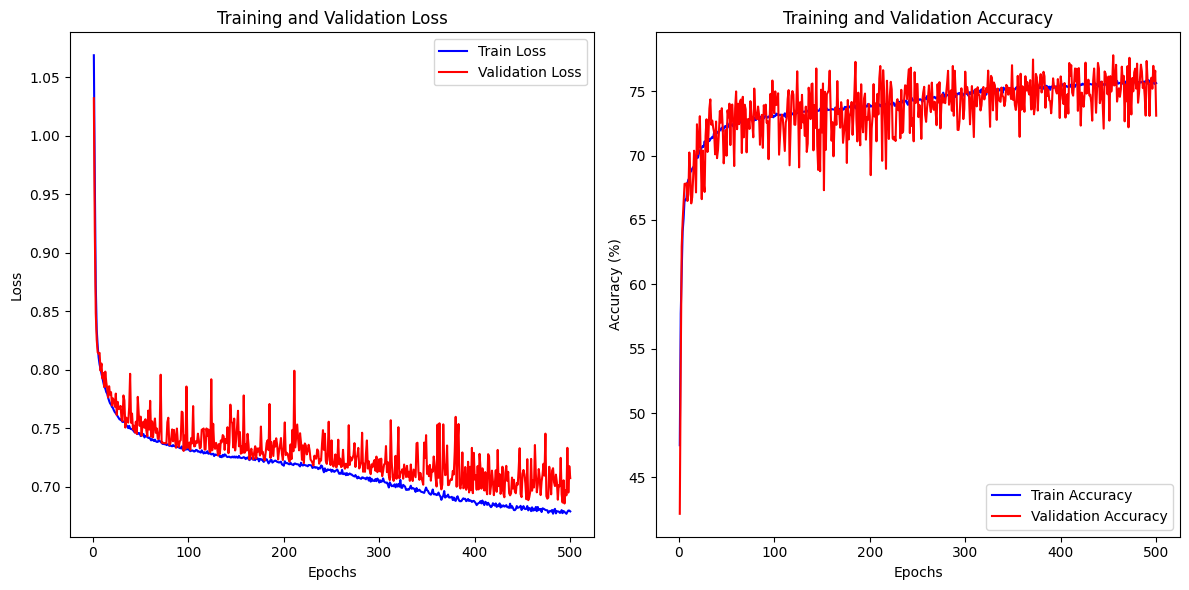

In [27]:
import matplotlib.pyplot as plt

# Vẽ đồ thị Loss và Accuracy
# Vẽ đồ thị Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Vẽ đồ thị Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

Đánh giá mô hình

In [28]:
# Đánh giá trên tập kiểm tra (test)
all_lbs = []
all_predictions = []
test_loss = 0.0
with torch.no_grad():
    model.eval()
    for images, targets in test_loader:
        images, targets = images.to(device), targets.to(device)
        targets_indices = torch.argmax(targets, dim=1)  # Chuyển sang class indices

        outputs = model(images)
        loss = criterion(outputs, targets_indices)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)

        all_lbs.extend(targets_indices.cpu().flatten().numpy())
        all_predictions.extend(predicted.cpu().flatten().numpy())

Test Loss: 0.6977


<Figure size 800x800 with 0 Axes>

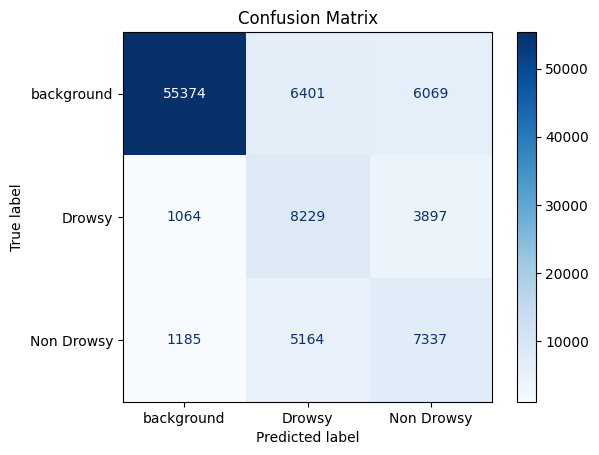

Precision: 0.81
Recall: 0.75
F1 Score: 0.77

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.82      0.88     67844
           1       0.42      0.62      0.50     13190
           2       0.42      0.54      0.47     13686

    accuracy                           0.75     94720
   macro avg       0.60      0.66      0.62     94720
weighted avg       0.81      0.75      0.77     94720



In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Tính test loss trung bình
test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

# Tính ma trận nhầm lẫn
cm = confusion_matrix(all_lbs, all_predictions, labels=[0, 1, 2])

# Hiển thị ma trận nhầm lẫn
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['background', 'Drowsy', 'Non Drowsy'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

precision = precision_score(all_lbs, all_predictions, average='weighted')
recall = recall_score(all_lbs, all_predictions, average='weighted')
f1 = f1_score(all_lbs, all_predictions, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# In báo cáo chi tiết
print("\nClassification Report:")
print(classification_report(all_lbs, all_predictions))

Chạy thử model

Input shape: torch.Size([1, 1, 128, 128])
Target shape: torch.Size([1, 3, 16, 16])
Target segmentation map (first few values): tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

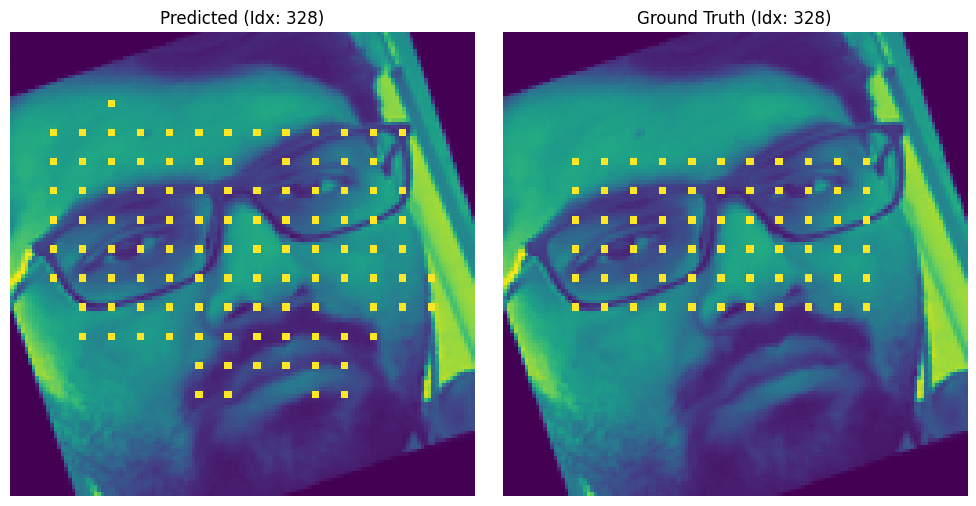

In [36]:
import torch
import random
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),   # Chuyển PIL Image thành tensor (shape: 1, 128, 128)
    transforms.Normalize(mean=[0.5], std=[0.5])  # Chuẩn hóa cho ảnh grayscale
])

# Chạy thử mô hình trên một ảnh test
idx = random.randint(0, len(X_test) - 1)
#idx = 6  # Gán cứng để kiểm tra
image = X_test[idx]

model.eval()
# Chuẩn bị đầu vào
image_pil = Image.fromarray((image.squeeze() * 255).astype(np.uint8), mode='L')
x = transform(image_pil).unsqueeze(0).to(device)  # Shape: (1, 1, 128, 128)
y = bbox_to_segmentation(image.shape, y_test[idx], 16, num_classes=2).unsqueeze(0).to(device)  # Shape: (1, 3, 16, 16)
y_target = torch.argmax(y, dim=1)  # Shape: (1, 16, 16)

print("Input shape:", x.shape)
print("Target shape:", y.shape)

with torch.no_grad():
    output = model(x)  # Shape: (1, 3, 16, 16)
    _, y_predicted = torch.max(output, 1)  # Shape: (1, 16, 16)

# Hiển thị kết quả
print(f"Target segmentation map (first few values): {y_target[::]}")
print(f"Predicted segmentation map (first few values): {y_predicted[::]}")

plt.figure(figsize=(10, 5))

# Ảnh gốc với tâm dự đoán
plt.subplot(1, 2, 1)
centers_pred = export_center(y_predicted[0], image.shape)
plt.imshow(draw_center(image, centers_pred))
plt.title(f"Predicted (Idx: {idx})")
plt.axis('off')

# Ảnh gốc với tâm ground truth
plt.subplot(1, 2, 2)
centers_target = export_center(y_target[0], image.shape)
plt.imshow(draw_center(image, centers_target))
plt.title(f"Ground Truth (Idx: {idx})")
plt.axis('off')

plt.tight_layout()
plt.show()

Chuyển đổi sang OnnxRuntime

In [39]:
import torch
import onnxruntime as ort

# Đặt mô hình ở chế độ đánh giá
model.eval()

# Dummy input (kích thước phải giống với kích thước đầu vào của mô hình)
# Ví dụ: Input [batch_size=1, channels=3, height=224, width=224]
dummy_input = torch.randn(1, 1, 128, 128).to(device)  # Đầu vào grayscale

# Đường dẫn lưu mô hình ONNX
onnx_file_path = r"model\best_model_grayscale_128x128_24_05_2025.onnx"

# Xuất mô hình sang định dạng ONNX
torch.onnx.export(
    model,                        # Mô hình PyTorch
    dummy_input,                  # Dummy input
    onnx_file_path,               # Đường dẫn lưu file .onnx
    export_params=True,           # Lưu tất cả tham số (weights) vào ONNX
    opset_version=12,             # Phiên bản ONNX (tùy chỉnh, thường dùng 11 hoặc 12)
    do_constant_folding=True,     # Tối ưu hóa các hằng số trong mô hình
    input_names=["input"],        # Tên đầu vào (có thể đặt tùy ý)
    output_names=["output"],      # Tên đầu ra (có thể đặt tùy ý)
    dynamic_axes={                # Định nghĩa trục động (batch size)
        "input": {0: "batch_size"},
        "output": {0: "batch_size"}
    }
)

print(f"Model has been converted to ONNX and saved at {onnx_file_path}")

Model has been converted to ONNX and saved at D:\Duc_PC\Hoc_AI_lap_trinh\notebook_edge_ai\ModelAI\best_model_grayscale_128x128_24_05_2025.onnx


In [38]:
!pip install onnx

   ---------------------------------------- 0.0/15.9 MB ? eta -:--:--
   ---------------------------------- ----- 13.6/15.9 MB 71.5 MB/s eta 0:00:01
   ---------------------------------------- 15.9/15.9 MB 62.4 MB/s eta 0:00:00
